In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [2]:
def plot_training_hist(training_hist):
    '''
    training_hist: Dataframe constructed from hist.hist from training results.
    '''
    f, a = plt.subplots(1)
    a.plot(training_hist['loss'], label='loss')
    a.plot(training_hist['val_loss'], label='validation loss')
    a.set_xlabel('Epoch')
    a.set_ylabel('Error [Sales Price]')
    a.grid(1)
    a.legend()

In [3]:
def calcate_fig_shape(cols):
    total_figs = len(cols)
    vlen = int(total_figs**0.5)
    hlen = int(np.ceil(total_figs / vlen))
    print(f"Shape of fig: {(vlen, hlen)}")
    return vlen, hlen

def plot_scatter_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        ax.scatter(pdf[col], pdf['SalePrice'])
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_box_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        all_cats = df[col].unique()
        ax.boxplot([pdf.loc[pdf[col]==c, 'SalePrice'] for c in all_cats], labels=all_cats)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_hist_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        all_cats = df[col].unique()
        counts = df[col].value_counts()
        counts = counts / counts.sum() * 100
        ax.bar(counts.index, counts)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        ax.set_ylabel('%')

    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

In [4]:
def label_columns(df, cols, label):
    for col in cols:
        df[col] = df[col].map(label).fillna(0).astype(int)

## Data Cleaning
1. NaN values
2. Label the categorical values with order -- 주로 qualitative grade.
    - pd.get_dummy 에서 NaN column사용하는 것도 생각해봐.

In [5]:
train_df = pd.read_csv('rsc/train.csv')
test_df = pd.read_csv('rsc/test.csv')

In [6]:
# Merge Train and test data to Fill NaN values
df= pd.concat([train_df, test_df]).reset_index(drop=True)

In [7]:
# Columns with NaN.
nan_count = df.isna().sum() 
nan_count_table = (nan_count[nan_count > 0] / len(df) * 100).round(2).to_frame("NaN Precent [%]")
print("Columns that have NaN values:", )
nan_count_table

Columns that have NaN values:


,NaN Precent [%]
MSZoning,0.14
LotFrontage,16.65
Alley,93.22
Utilities,0.07
Exterior1st,0.03
Exterior2nd,0.03
MasVnrType,0.82
MasVnrArea,0.79
BsmtQual,2.77
BsmtCond,2.81


In [8]:
# Separate the categorical columns and numeric columns.
categorical_cols = df.dtypes[df.dtypes == object].index
numeric_cols = df.dtypes[df.dtypes != object].index

In [9]:
# Columns with NA category
na_cat = ['Alley', 'MasVnrType','GarageType', 'MiscFeature']
for c in na_cat:
    df[c] = df[c].fillna('NA')

# Columns that NaN should be zero -- numeric
zero_cat = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for c in na_cat:
    df[c] = df[c].fillna(0)

In [10]:
# Categorical cols' NaN get mode
for c in categorical_cols:
    df[c] = df[c].fillna(df[c].mode()[0])
# Numeric cols' NaN get median
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

In [11]:
# Columns with NaN.
tot_nan_count = df.isna().sum().sum()
print('NaN count', tot_nan_count)

NaN count 0


### Label Qualitative Columns

In [12]:
# columns : labels -- int, qualitative
grading_scheme =[
    (['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'], {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2,'Po':1, np.nan:0}),
    (['BsmtExposure'], {'Gd':4, 'Av':3, 'Mn':2,'No':1, np.nan:0}),
    (['BsmtFinType1', 'BsmtFinType2'], {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1, np.nan:0}),
    (['Functional'], {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4,'Maj1':3,'Maj2':2, 'Sev':1, 'Sal':0}),
    (['GarageFinish'], {'Fin':3, 'RFn':2,'Unf':1, np.nan:0}),
    (['PavedDrive', 'CentralAir'], {'Y':2,'P':1,'N':0}),
    (['Fence'], {'GdPrv':4, 'MnPrv':3, 'GdWo':2,'MnWw':1, np.nan:0})
]
for cols_to_label, label in grading_scheme:
    label_columns(df, cols_to_label, label)

In [13]:
# Separate the categorical columns and numeric columns.
categorical_cols = df.dtypes[df.dtypes == object].index
numeric_cols = df.dtypes[df.dtypes != object].index

## Feature Selection
### 1. Categorical

First, let's look at the categorical features. I want features that are at least somewhat evenly distributed.\
If a feature is not evenly distributed, it cannot be a good distinguishing factor.\
I don't want any feature that has one category dominating more than 70% of the sample.

In [14]:
train_df = df[:len(train_df)]
test_df = df[len(train_df):].drop(columns=['SalePrice'])

In [15]:
def find_unevenly_dist_cols(df, cols):
    '''
    Use this for categorical columns
    '''
    uneven_cat_cols = []
    for c in cols:
        counts = df[c].value_counts()
        counts /= counts.sum()
        if (counts > 0.7).any():
            uneven_cat_cols.append(c)
    return uneven_cat_cols

In [16]:
uneven_cat_cols = find_unevenly_dist_cols(df, categorical_cols)
even_cat_cols = set(categorical_cols) - set(uneven_cat_cols)

Shape of fig: (2, 4)


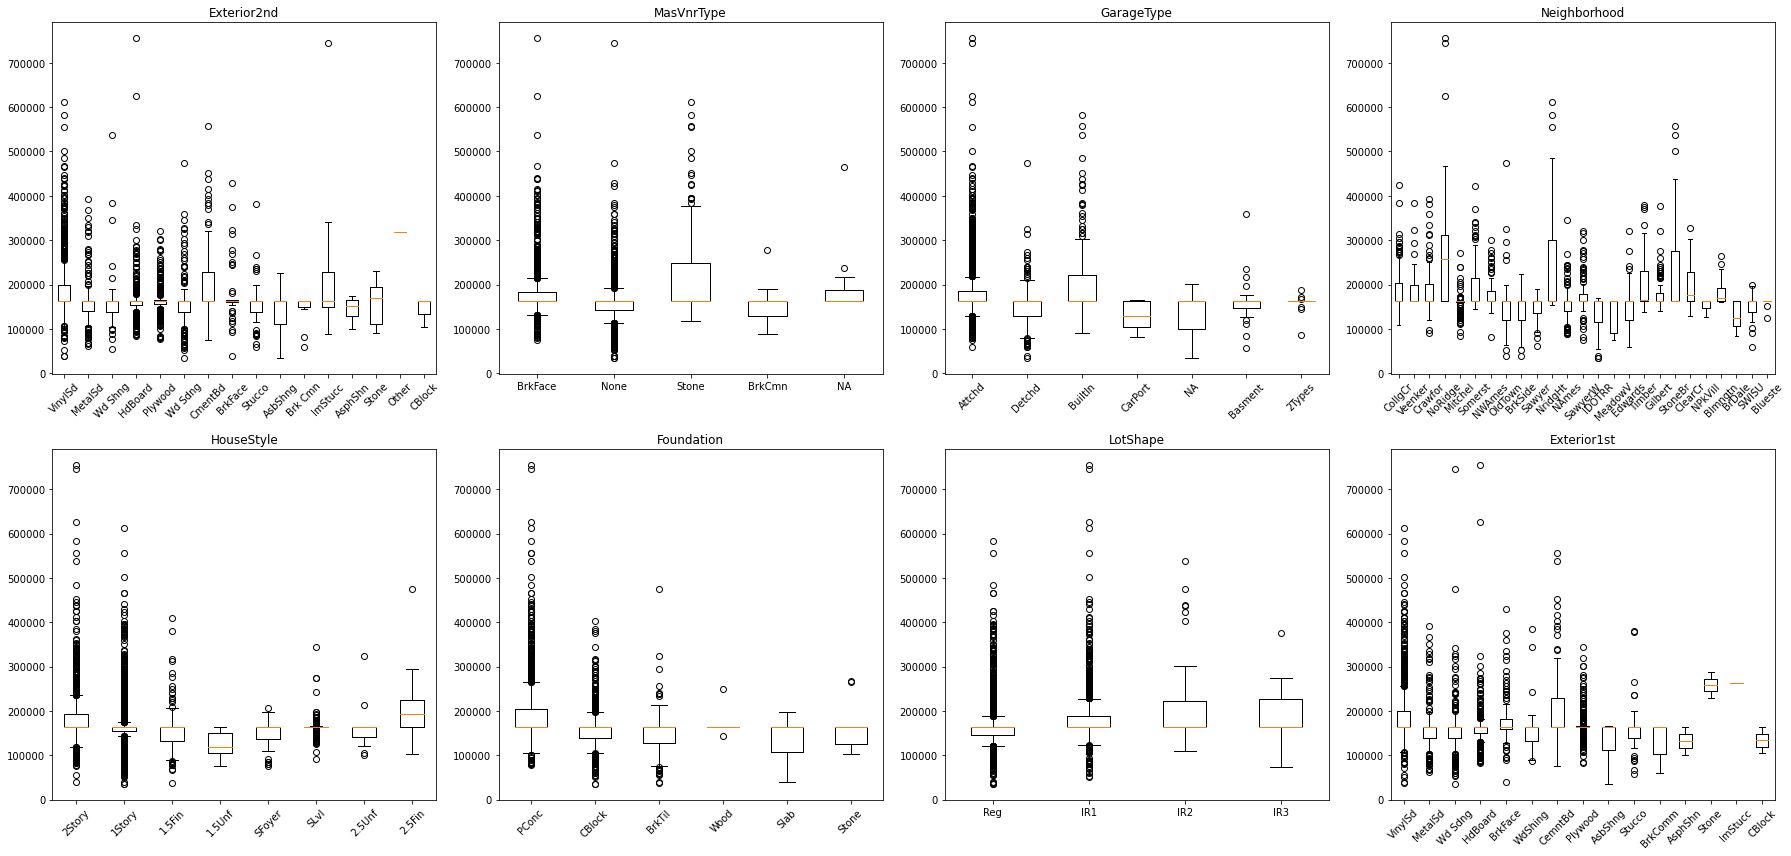

In [17]:
plot_box_matrix(df, even_cat_cols)

Most of the features' categories are distinguishing.\
but Exterior features for example, may not be too effective as there are many different categories without significant difference in median.

### 2. Numerical
This set includes qualitative features that were converted to integer values.\
Same procedure goes here. Start with the distribution.

Shape of fig: (7, 8)


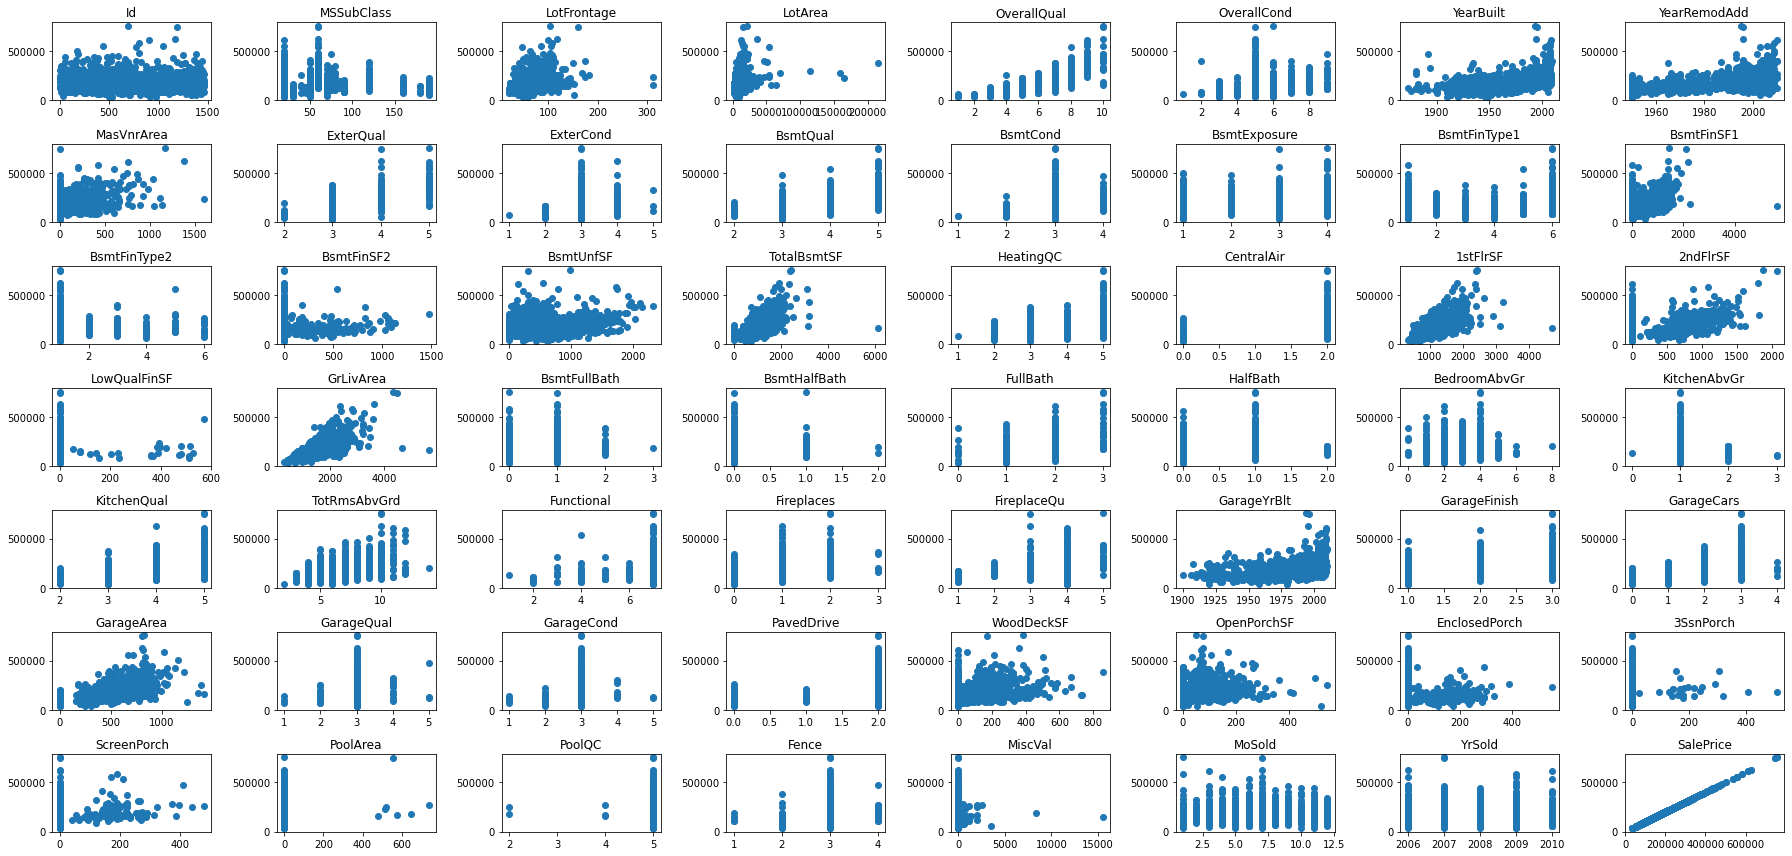

In [18]:
#여기는 train only. SalePrice가 필요하니깐
plot_scatter_matrix(train_df, numeric_cols)

It's easy to spot features that have correlations from the graph.\
But let's calculate the correlation coefficient to quantify the relationships.\
I'll be starting with features with correlation coeff higher than 0.5. -- start with the obivous ones.

In [19]:
#여기는 train only. SalePrice가 필요하니깐
corr = train_df[numeric_cols].corr()
strong_numeric_features = corr['SalePrice'][corr['SalePrice'].abs() > 0.5].index
print("strong numeric features", len(strong_numeric_features))
print(strong_numeric_features.tolist())

strong numeric features 15
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageFinish', 'GarageCars', 'GarageArea', 'SalePrice']


In [20]:
def plot_correlation_heatmap(df, cols):
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(df[cols].corr())
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)
    ax.set_title('Correlation plot')
    _ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    _ = cbar.ax.set_ylabel("Pearson score", rotation=-90, va="bottom")

Now, I need to check for colinearity between the strong features.

There seems to be some correlation between the strong features. I need to avoid this. \
Let's quantify this.

In [21]:
# selected_numeric = handle_collinearity(high_corr_df)
selected_numeric = strong_numeric_features  # 안하는 게 더 낫다.

In [22]:
print("Categoricals, :", even_cat_cols)
print("Numercals, :", set(selected_numeric))

Categoricals, : {'Exterior2nd', 'MasVnrType', 'GarageType', 'Neighborhood', 'HouseStyle', 'Foundation', 'LotShape', 'Exterior1st'}
Numercals, : {'ExterQual', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'KitchenQual', 'YearBuilt', 'OverallQual', 'BsmtQual', 'GarageCars', 'GarageFinish', 'YearRemodAdd', 'FullBath', 'TotRmsAbvGrd', 'SalePrice', '1stFlrSF'}


In [23]:
df_onehot = pd.get_dummies(df, columns=even_cat_cols, drop_first=True)
total_dataset = df_onehot
train_dataset = df_onehot[:len(train_df)]
test_dataset = df_onehot[len(train_df):]
target = df[:len(train_df)]['SalePrice']

In [24]:
# Trial & Error
numeric_final = selected_numeric #['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual','TotalBsmtSF','GrLivArea', 'GarageCars']
categorical_prefix = even_cat_cols #['LotShape', 'Neighborhood']
categorical_final = []
for c in categorical_prefix:
    categorical_final.extend(train_dataset.columns[train_dataset.columns.map(lambda x: x.startswith(c))])

final_features = [*numeric_final, *categorical_final]
total_input = total_dataset[final_features]
train_input= train_dataset[final_features]
test_input= test_dataset[final_features].drop(["SalePrice"],axis=True)

# 역효과: 'FullBath', 'FireplaceQu','GarageFinish', 'Foundation', 'Exterior1st', 'GarageType', 'MasVnrType', 'Exterior2nd', 'HouseStyle'
# Numeric
# 'BsmtQual', 'KitchenQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', '1stFlrSF', 
# 'GarageArea', 'ExterQual', 'YearRemodAdd', 'TotRmsAbvGrd', 'YearBuilt', 'GarageFinish', 'OverallQual', 'GarageCars', 'SalePrice'
# Categorical
# 'Foundation', 'LotShape', 'HouseStyle', 'Exterior2nd', 'GarageType', 'Exterior1st', 'MasVnrType', 'Neighborhood'

# Regression Part

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNetCV, BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, make_scorer 
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import math

In [40]:
total_input

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,GrLivArea,GarageCars,SalePrice,LotShape_IR2,LotShape_IR3,LotShape_Reg,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,7,2003,2003,4,856.0,1710,2.0,208500.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,1976,1976,3,1262.0,1262,2.0,181500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7,2001,2002,4,920.0,1786,2.0,223500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,1915,1970,3,756.0,1717,3.0,140000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,2000,2000,4,1145.0,2198,3.0,250000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,4,1970,1970,3,546.0,1092,0.0,163000.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2915,4,1970,1970,3,546.0,1092,1.0,163000.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2916,5,1960,1996,3,1224.0,1224,2.0,163000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2917,5,1992,1992,3,912.0,970,0.0,163000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
total_input.shape

(2919, 35)

In [42]:
#Training data after preproscing
target = train_input['SalePrice']
train_input.shape

(1460, 35)

In [43]:
#Testing data after preproscing
test_input.shape

(1459, 34)

In [44]:
#here we add salePrice column in traning data
train_input.head()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,GrLivArea,GarageCars,SalePrice,LotShape_IR2,LotShape_IR3,LotShape_Reg,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,7,2003,2003,4,856.0,1710,2.0,208500.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,1976,1976,3,1262.0,1262,2.0,181500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7,2001,2002,4,920.0,1786,2.0,223500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,1915,1970,3,756.0,1717,3.0,140000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,2000,2000,4,1145.0,2198,3.0,250000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [45]:
x=train_input.drop(["SalePrice"],axis=True)
y=target

In [57]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=40)

GBoost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
#RMSE estimated through the partition of the train set
GBoost.fit(x_train, y_train)
rmse = np.sqrt(mean_squared_error(y_test, GBoost.predict(x_test)))
print("RMSE: %.4f" % rmse)

RMSE: 27188.0150


In [58]:
print(GBoost.score(x_test,y_test))

0.8580299403904634


In [50]:
num_col=test_input._get_numeric_data().columns.tolist()

cat_col=set(test_input.columns)-set(num_col)


In [51]:
for col in num_col:
    test_input[col].fillna(test_input[col].mean(),inplace=True)

for col in cat_col:
    test_input[col].fillna(test_input[col].mode()[0],inplace=True)

In [52]:
y_model_prerfc = GBoost.predict(test_input)
y_model_prerfc=np.around(y_model_prerfc,0)
prediction=np.array(y_model_prerfc).tolist()

test_df['SalePrice'] = prediction
test_df[['Id', 'SalePrice']].to_csv('results/my_data_GB.csv',index=False)
test_df[['Id', 'SalePrice']].head()

,Id,SalePrice
1460,1461,109481.0
1461,1462,150828.0
1462,1463,171255.0
1463,1464,179787.0
1464,1465,191396.0
